In [1]:
import numpy as np
import math
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from astropy import units as u
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

rcParams["font.family"] = "serif"

In [2]:
def etc(SN, telescope_diameter, wavelength, dLambda, Bbkg_mag_asec2, RN, aperture_diam):

    telescope_diameter = telescope_diameter * u.m
    wavelength = wavelength * u.Angstrom

    mags = np.geomspace(17.5, 100, 100)

    # computing fluxes, using G-band
    Phi_zero_point = 1392.6 * (u.cm**-2 * u.s**-1 * u.Angstrom**-1)
    # Phi_zero_point = Phi_zero_point.to(u.m**-2 * u.s**-1 * u.m**-1).value
    photon_flux = Phi_zero_point.value * 10 ** -(0.4 * mags)
    # print(Phi_zero_point)

    # computing photometery aperture area
    # radians
    phi_diff_fwhm_rad = wavelength.to(u.m).value / telescope_diameter.value  # radians
    phi_diff_fwhm_arcsec = phi_diff_fwhm_rad * (180 / np.pi) * 3600  # arcesec
    Omega = (np.pi / 4) * (aperture_diam * phi_diff_fwhm_arcsec) ** 2  # arcsec^2

    backgroun_flux_per_arsec2 = Phi_zero_point.value * 10 ** -(0.4 * Bbkg_mag_asec2)
    # background_flux = backgroun_flux_per_arsec2
    # solid angle to arsec^2
    # Omega *= 1.3 * 1e7

    # print("Omega", Omega)

    # effective light collecting area
    epsilon = 0.5
    area_eff = epsilon * np.pi * (telescope_diameter.to(u.cm).value / 2) ** 2
    # print("Area eff [cm^2]", area_eff)

    # quad. formula
    a = (photon_flux * area_eff * dLambda) ** 2
    b = (
        -(SN**2)
        * (1 + ((backgroun_flux_per_arsec2 * Omega) / photon_flux))
        * photon_flux
        * area_eff
        * dLambda
    )
    c = -(SN**2 * RN**2)
    # both solutions
    x1 = (-b + np.sqrt(b**2 - (4 * a * c))) / (2 * a)
    x2 = (-b - np.sqrt(b**2 - (4 * a * c))) / (2 * a)
    # print(x1, x2)
    # take positive solution
    t_exp = []
    for i, x in enumerate(x1):
        if x > 0:
            t_exp.append(x)
        else:
            t_exp.append(x2[i])

    # print(t_exp)
    return mags, np.array(t_exp)

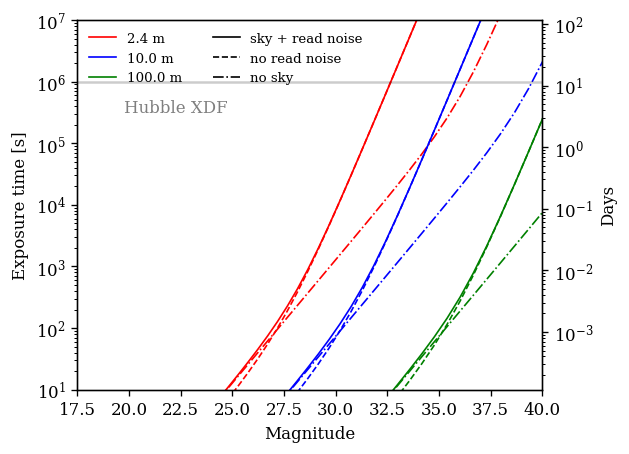

In [3]:
SN = 5.0  # Desired signal-to-noise ratio
RN = 5.0  # Read Noise

dLambda = 1000  # angstroms
Bbkg_mag_asec2 = 22  # background intensity in units of magnitudes per arcsecond^2
wavelength = 5000  # wavelength in units of angstroms
aperture_diam = 2  # measurement aperture in units of diffraction-limited FWHM

# we need to set diameter, done in loop below, but for example:
diameter = 100  # meters


diamlist = np.array([2.4, 10, 100])  # meters
RN = [5, 0, 5]
Bbkg_mag_asec2 = [22, 22, 30]
color = ["red", "blue", "green"]

fig, ax = plt.subplots(1, 1, dpi=120, figsize=(5, 4))

for i, (d, col) in enumerate(zip(diamlist, color)):

    mag, t_exp = etc(
        SN=SN,
        telescope_diameter=d,
        wavelength=wavelength,
        dLambda=dLambda,
        Bbkg_mag_asec2=Bbkg_mag_asec2[0],
        RN=RN[0],
        aperture_diam=aperture_diam,
    )
    ax.plot(
        mag, t_exp, lw=1, color=col, label="{:.1f} m ".format(d)
    )  # sky and read noise

    mag, t_exp = etc(
        SN=SN,
        telescope_diameter=d,
        wavelength=wavelength,
        dLambda=dLambda,
        Bbkg_mag_asec2=Bbkg_mag_asec2[1],
        RN=RN[1],
        aperture_diam=aperture_diam,
    )
    ax.plot(mag, t_exp, lw=1, ls="--", color=col)  # no read noise

    mag, t_exp = etc(
        SN=SN,
        telescope_diameter=d,
        wavelength=wavelength,
        dLambda=dLambda,
        Bbkg_mag_asec2=Bbkg_mag_asec2[2],
        RN=RN[2],
        aperture_diam=aperture_diam,
    )
    ax.plot(mag, t_exp, lw=1, ls="-.", color=col)  # without background sky

ax.set_yscale("log")
ax.set_ylim(10, 1e7)
ax.set_xlim(17.5, 40)
ax.axhline(y=1e6, color="k", alpha=0.2)
ax.set_xlabel("Magnitude")
ax.set_ylabel("Exposure time [s]")

handles, labels = plt.gca().get_legend_handles_labels()

# create manual symbols for legend

line1 = Line2D([0], [0], label="sky + read noise", lw=1, color="k")
line2 = Line2D([0], [0], label="no read noise", ls="--", lw=1, color="k")
line3 = Line2D([0], [0], label="no sky", ls="-.", lw=1, color="k")

handles.extend([line1, line2, line3])
# plot the legend
ax.legend(handles=handles, loc="upper left", ncols=2, fontsize=8, frameon=False)
ax.text(0.1, 0.75, "Hubble XDF", alpha=0.5, transform=ax.transAxes)

days_ax = ax.twinx()
days_ax.plot(mag, t_exp / (60 * 60 * 24), alpha=0)
days_ax.set_yscale("log")
days_ax.set_ylim(10 / (60 * 60 * 24), 1e7 / (60 * 60 * 24))
days_ax.set_ylabel("Days")

plt.show()

Here we see the exposure time as a function of object magnitude for three different telescope diameters: 2.4 m, 10.0 m, and 100 m. 
Including the sky and the read noise (solid lines) changes the exposure time significantly, with the dominant contribution being from the sky (no sky exposure are indicated with the dash-dot lines). Ignoring the read noise proved the least consequential and are more noticeable for low exposure times (< 100 seconds).  

### Discovery objects for the 100m space telescope. 

In class we discussed several topic areas for discovery including:

- Distant exoplanets and exomoons
- Supermassive black holes (including stellar orbits around those in other galaxies)
- First Stars, Clusters or Galaxies in the Universe
- Precision signatures of dark matter

Choose one topic area from above (or any other) and determine the feasibility of making an exciting discovery with the 100m Space Telescope.  

For our purposes "feasibility" means: Does it have a detectable apparent magnitude in the visible/NIR in a reasonable exposure time?

To answer this, you would need to know an object's absolute magnitude (or luminosity) and distance, along with the expected wavelength of the signal.

Using your exposure time calculator, determine the feasibility of detecting (e.g. with S/N~5, in 1e6 seconds) ONE type of 'discovery' object.  Though note: if too easy to observe, consider pushing the limits!

Suppose we try to observe a high redshift galaxy that is 1 Myr old at a $z=11$. It has the following rest-frame luminosity from all  $10^6 ~{\rm M_\odot}$ stars. That we have also corrected for redshift via $F_{\rm obs} = L ({4\pi D^2_L})^{-1}$ where the luminosity distance $D_L$ at this redshift is $\sim 115 Gpc$.

![alt text|90](./luminosity_correction.png)

We can calculate the apparent magnitude of this object at, let's say, at 1 $\mu m$. Which in this case $F_{gal} = 10^{-21} (erg/s/cm^{-2})$

$$m_{\rm gal}  = -2.5 \log_{10} \dfrac{F_{\rm gal}}{F_{\rm sun}} +  m_{\rm sun}$$

From this, we can use the sun as a comparion https://en.wikipedia.org/wiki/Solar_irradiance#/media/File:Solar_spectrum_en.svg

With $F_{\rm sun} \sim 0.5 W/m^2$ at 1 $\mu m$, which is roughly $500.0 ~(erg/s/cm^{-2})$, $m_{ sun} = -26.74$

In [4]:
mgal = -2.5 * np.log10(1e-21 / 500) - 26.74
print("galaxy at z=11, apparent magnitude", mgal)
Mgal = mgal - 5 * (np.log10(115e9) - 1)
print("galaxy at z=11, absolute magnitude", Mgal)

galaxy at z=11, apparent magnitude 32.50742501084005
galaxy at z=11, absolute magnitude -17.796064190928007


What if instead an entire galaxy, we try to get just 1 star, we can simply scale down the luminosity accoridng to the solar mass, so let's assume a 100 Msun popIII star, which means 100/1e6 = 0.0001, which gives us $F_{PopIII} = 10^{-25} (erg/s/cm^{-2})$

In [5]:
m_firststar = -2.5 * np.log10(1e-25 / 500) - 26.74
print("pop3 at z=11, apparent magnitude", m_firststar)
M_firststar = mgal - 5 * (np.log10(115e9) - 1)
print("pop3 at z=11, absolute magnitude", M_firststar)

pop3 at z=11, apparent magnitude 42.50742501084005
pop3 at z=11, absolute magnitude -17.796064190928007


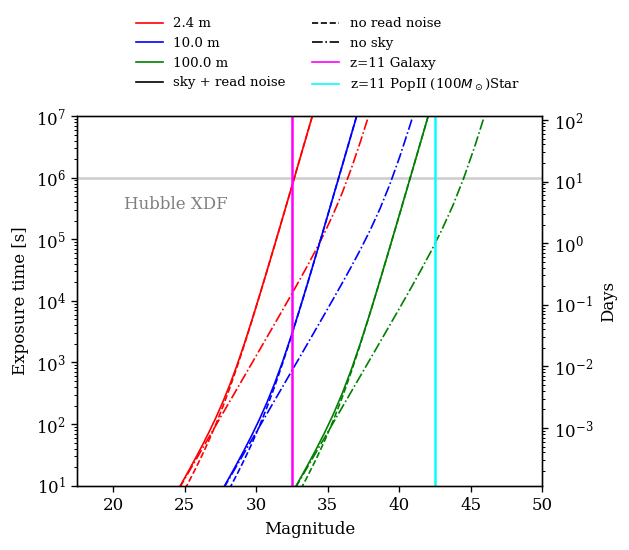

In [6]:
SN = 5.0  # Desired signal-to-noise ratio
RN = 5.0  # Read Noise

dLambda = 1000  # angstroms
Bbkg_mag_asec2 = 22  # background intensity in units of magnitudes per arcsecond^2
wavelength = 5000  # wavelength in units of angstroms
aperture_diam = 2  # measurement aperture in units of diffraction-limited FWHM

# we need to set diameter, done in loop below, but for example:
diameter = 100  # meters


diamlist = np.array([2.4, 10, 100])  # meters
RN = [5, 0, 5]
Bbkg_mag_asec2 = [22, 22, 30]
color = ["red", "blue", "green"]

fig, ax = plt.subplots(1, 1, dpi=120, figsize=(5, 4))

for i, (d, col) in enumerate(zip(diamlist, color)):

    mag, t_exp = etc(
        SN=SN,
        telescope_diameter=d,
        wavelength=wavelength,
        dLambda=dLambda,
        Bbkg_mag_asec2=Bbkg_mag_asec2[0],
        RN=RN[0],
        aperture_diam=aperture_diam,
    )
    ax.plot(
        mag, t_exp, lw=1, color=col, label="{:.1f} m ".format(d)
    )  # sky and read noise

    mag, t_exp = etc(
        SN=SN,
        telescope_diameter=d,
        wavelength=wavelength,
        dLambda=dLambda,
        Bbkg_mag_asec2=Bbkg_mag_asec2[1],
        RN=RN[1],
        aperture_diam=aperture_diam,
    )
    ax.plot(mag, t_exp, lw=1, ls="--", color=col)  # no read noise

    mag, t_exp = etc(
        SN=SN,
        telescope_diameter=d,
        wavelength=wavelength,
        dLambda=dLambda,
        Bbkg_mag_asec2=Bbkg_mag_asec2[2],
        RN=RN[2],
        aperture_diam=aperture_diam,
    )
    ax.plot(mag, t_exp, lw=1, ls="-.", color=col)  # without background sky

ax.set_yscale("log")
ax.set_ylim(10, 1e7)
ax.set_xlim(17.5, 50)
ax.axhline(y=1e6, color="k", alpha=0.2)
ax.set_xlabel("Magnitude")
ax.set_ylabel("Exposure time [s]")

handles, labels = plt.gca().get_legend_handles_labels()

# create manual symbols for legend

line1 = Line2D([0], [0], label="sky + read noise", lw=1, color="k")
line2 = Line2D([0], [0], label="no read noise", ls="--", lw=1, color="k")
line3 = Line2D([0], [0], label="no sky", ls="-.", lw=1, color="k")
line4 = Line2D([0], [0], label="z=11 Galaxy", lw=1, color="magenta")
line5 = Line2D([0], [0], label=r"z=11 PopII (100$M_\odot$)Star", lw=1, color="cyan")

handles.extend([line1, line2, line3, line4, line5])
# plot the legend
ax.legend(
    handles=handles,
    loc="upper left",
    ncols=2,
    fontsize=8,
    frameon=False,
    bbox_to_anchor=(0.1, 1.3),
)
ax.text(0.1, 0.75, "Hubble XDF", alpha=0.5, transform=ax.transAxes)

days_ax = ax.twinx()
days_ax.plot(mag, t_exp / (60 * 60 * 24), alpha=0)
days_ax.set_yscale("log")
days_ax.set_ylim(10 / (60 * 60 * 24), 1e7 / (60 * 60 * 24))
days_ax.set_ylabel("Days")

ax.axvline(mgal, color="magenta")
ax.axvline(m_firststar, color="cyan")

plt.show()

```
1. Discovery objects for the 100m space telescope. 

In class we discussed several topic areas for discovery including:

Distant exoplanets and exomoons
Supermassive black holes (including stellar orbits around those in other galaxies)
First Stars, Clusters or Galaxies in the Universe
Precision signatures of dark matter
Choose one topic area from above (or any other) and determine the feasibility of making an exciting discovery with the 100m Space Telescope.  For our purposes "feasibility" means: Does it have a detectable apparent magnitude in the visible/NIR in a reasonable exposure time?

To answer this, you would need to know an object's absolute magnitude (or luminosity) and distance, along with the expected wavelength of the signal.

Using your exposure time calculator, determine the feasibility of detecting (e.g. with S/N~5, in 1e6 seconds) ONE type of 'discovery' object.  Though note: if too easy to observe, consider pushing the limits!
```

Here we introduce the plausability of detecting two objects at high redshifts: a 1e6 Msun galaxy with spectra generated from starburst99, and a scaled down version of this, with just the lumniosity contributing from a 100 solar mass pop 3 star. We see that the high redshift galaxy can be detected within 1e6 second using the 2.4 and 10 m telecopse. However, the popIII star need a 100 m telescope to be detected within this time at an apparent magnitude of ~42.50.

Note, there are several caveats of this result. Note, we don't take into account the extent of the object; i.e. an observatory must have an adequate enough resolving power to study the morphology of the source. In many cases, we can already uncover some of these objects with JWST due to luck from strong gravitational lensing that can amplify the apparent magnitude due to surface brightness conservation during strong lensing.

In short, it is feasable with the 100 telescope. In reality, you'd probably also place this in space so that the bakcground is minimal. 